In [1]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,Conv2D
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import Dense, Dropout, LSTM, Embedding, Activation, Lambda, Bidirectional
from tensorflow.keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

2023-08-04 18:22:31.733138: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 18:22:31.752816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU device:", gpu)
        print("number of GPU device: ",len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU devices found.")


#tf.config.experimental.set_memory_growth(gpus[0], True)

GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
number of GPU device:  1


2023-08-04 18:22:32.763817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 18:22:32.777454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 18:22:32.777535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
from kerastuner import HyperModel, RandomSearch

/tmp/ipykernel_735088/3805274735.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [4]:
%run 'lstminput.ipynb'

/tmp/ipykernel_735088/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/tmp/ipykernel_735088/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_735088/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [5]:
train_x_tensor.shape

(8000, 450, 5)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, TimeDistributed, Dense
from kerastuner.tuners import RandomSearch
import kerastuner

In [7]:
class MyHyperModel(kerastuner.HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=512, step=32), return_sequences=True),input_shape=(450,5)))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=512, step=32), return_sequences=True)))
        model.add(TimeDistributed(Dense(self.num_classes, activation='softmax')))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model



In [8]:
hypermodel = MyHyperModel(num_classes=5)

In [9]:
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=2,
    directory='random_search',
    project_name='lstm_shm')



INFO:tensorflow:Reloading Tuner from random_search/lstm_shm/tuner0.json


In [10]:
tuner.search_space_summary()



Search space summary
Default search space size: 3
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
log_dir = "logs/LSTM/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10)
tuner.search(train_x_tensor, train_y_tensor, epochs=150, validation_data=(test_x_tensor, test_y_tensor), batch_size=64, callbacks=[tf_callback, early_stopping_callback])



INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.get_best_hyperparameters()

In [14]:
tuner.results_summary()

Results summary
Results in random_search/lstm_shm
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
lstm_units: 224
dropout: 0.0
learning_rate: 0.001
Score: 0.9908483326435089

Trial 13 summary
Hyperparameters:
lstm_units: 32
dropout: 0.30000000000000004
learning_rate: 0.01
Score: 0.9902572333812714

Trial 02 summary
Hyperparameters:
lstm_units: 64
dropout: 0.0
learning_rate: 0.001
Score: 0.9900799989700317

Trial 03 summary
Hyperparameters:
lstm_units: 192
dropout: 0.0
learning_rate: 0.001
Score: 0.9898810982704163

Trial 05 summary
Hyperparameters:
lstm_units: 32
dropout: 0.30000000000000004
learning_rate: 0.001
Score: 0.9779488742351532

Trial 16 summary
Hyperparameters:
lstm_units: 288
dropout: 0.30000000000000004
learning_rate: 0.0001
Score: 0.9765044450759888

Trial 08 summary
Hyperparameters:
lstm_units: 96
dropout: 0.4
learning_rate: 0.001
Score: 0.9708505570888519

Trial 14 summary
Hyperparameters:
lstm_units: 192
dropout

In [15]:
import time

In [16]:
best_model = tuner.get_best_models(num_models=1)[0]

2023-08-04 18:22:49.612360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 18:22:49.612469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 18:22:49.612511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

2023-08-04 18:22:54.900649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 18:22:54.901226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 18:22:54.901958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 4/63 [>.............................] - ETA: 1s  

2023-08-04 18:22:55.705551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-08-04 18:22:55.781342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 3s 26ms/step


([<matplotlib.axis.YTick at 0x7f20a3d95d90>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

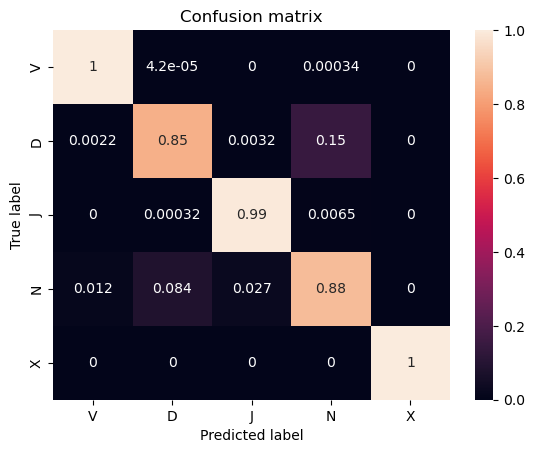

In [18]:
y_pred = best_model.predict(test_x_tensor)
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(test_y_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [20]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9908822222222222
Precision: 0.9471773361613977
Recall: 0.9433993275194534
F1 Score: 0.9451824925038835
